In [40]:
import torch
import time
import random
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import silhouette_score

### Load SILVA data

In [2]:
# Heavy file, takes a minute
silva_db = pd.read_table('C:/Users/efrat/Downloads/silva_138_release/Exports/SILVA_parsed_V2.tsv', index_col = 0,
                        dtype={'raw_id': str, 
                               "full_taxonomy": str, 
                               "seq_length": int,
                               "seq": str, 
                               "kingdom": str, 
                               "phylum": str, 
                               "class": str, 
                               "order": str, 
                               "family": str,
                               "genus": str,
                               "species": str,
                               "strain": str})
silva_db.head()

,raw_id,full_taxonomy,seq_length,seq,kingdom,phylum,class,order,family,genus,species,strain
0,HG531388.1.1375,Bacteria;Proteobacteria;Alphaproteobacteria;Rh...,1375,AGUCGAGCGGGCGCAGCAAUGCGUCAGCGGCAGACGGGUGAGUAAC...,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Rhodoplanes,Rhodoplanes oryzae,NaN
1,HL281785.3.1301,Bacteria;Bacteroidota;Bacteroidia;Bacteroidale...,1299,AUUCCGGGAUAGCCUUUCGAAAGAAAGAUUAAUACUGGAUAGCAUA...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,unidentified,NaN
2,AB002644.1.1485,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,1485,GGCUAAUACAUGCAAGUCGAGCGAGUGAACAAACAGAAGCCUUCGG...,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,low G+C Gram-positive bacterium HTA454,NaN
3,AB002648.1.1383,Bacteria;Firmicutes;Bacilli;Thermoactinomyceta...,1383,AGCGGCGAACGGGUGAGUAACACGNGGGUAACCUGCCCUCAAGACC...,Bacteria,Firmicutes,Bacilli,Thermoactinomycetales,Thermoactinomycetaceae,Thermoflavimicrobium,low G+C Gram-positive bacterium HTA1422,NaN
4,JN049459.1.1443,Bacteria;Actinobacteriota;Actinobacteria;Strep...,1443,GACAUGGCGCCUCUACCAUGCAGUCGACGAUGACCACCUUCGGGGU...,Bacteria,Actinobacteriota,Actinobacteria,Streptomycetales,Streptomycetaceae,Streptomyces,actinobacterium ZXY010,NaN


In [3]:
len(silva_db)

432033

### Load sequence-level embeddings

In [4]:
bpe_embed_path = "C:/Users/efrat/Documents/DNA_BERT_Data/bert_embeddings/averaged_embeddings_no_padding__weight2"
kmer_embed_path = "C:/Users/efrat/Documents/DNA_BERT_Data/bert_embeddings/averaged_embeddings_no_padding__weight2_kmer"

In [5]:
bpe_seq_embed = torch.load(bpe_embed_path)
bpe_seq_embed.shape

torch.Size([50000, 256])

In [6]:
kmer_seq_embed = torch.load(kmer_embed_path)
kmer_seq_embed.shape

torch.Size([50000, 256])

In [43]:
bpe_seq_embed_np = bpe_seq_embed.numpy()
kmer_seq_embed_np = kmer_seq_embed.numpy()

print(kmer_seq_embed_np)

# Remove first pc for BPE
svd = TruncatedSVD(n_components=1, n_iter=7, random_state=27)
svd.fit(bpe_seq_embed_np)
pc = svd.components_
bpe_seq_embed_np -= bpe_seq_embed_np.dot(pc.T) * pc

# Remove first pc for kmers
svd2 = TruncatedSVD(n_components=1, n_iter=7, random_state=27)
svd2.fit(kmer_seq_embed_np)
pc = svd2.components_
kmer_seq_embed_np -= kmer_seq_embed_np.dot(pc.T) * pc

print(kmer_seq_embed_np)

[[-1.20470391e-02 -4.82327762e-03 -2.47385743e-02 ...  2.15326197e-02
   3.84637925e-02 -2.11293528e-02]
 [-3.95955646e-02 -1.90780360e-02 -5.83400563e-03 ...  2.27586447e-03
  -3.35318825e-02 -2.98643961e-02]
 [ 1.72182767e-05 -2.18692264e-02  1.40286834e-02 ...  2.75221057e-02
  -1.74102503e-03  1.38175139e-02]
 ...
 [-2.64449570e-02  1.41964197e-02  1.04115981e-02 ... -4.54898323e-03
   2.43550977e-02 -2.56449511e-02]
 [ 1.91881697e-03  9.48857618e-03  8.13421289e-03 ...  4.63283565e-02
   2.80978338e-02  8.18436860e-03]
 [-1.88583710e-02 -4.98017274e-04  3.76041250e-03 ...  1.95572088e-02
   8.34610724e-03  2.65012571e-03]]
[[-0.00180003 -0.00470092 -0.03042652 ...  0.00752747  0.03136697
  -0.01161748]
 [-0.02223978 -0.01887079 -0.01546791 ... -0.02144523 -0.04555206
  -0.01375374]
 [ 0.01213973 -0.02172447  0.00729968 ...  0.0109536  -0.01013677
   0.02507035]
 ...
 [-0.0125261   0.01436262  0.00268547 ... -0.02357265  0.01471525
  -0.01272465]
 [ 0.01370754  0.00962934  0.001590

In [44]:
# Column names for embedding digits
feat_cols = [ 'emb'+str(i) for i in range(bpe_seq_embed.shape[1]) ]

# Convert into one data frame
df_bpe = pd.DataFrame(bpe_seq_embed_np, columns = feat_cols)

# Add tax' info from silva_db
df_bpe['phylum'] = silva_db.head(50000)['phylum']
df_bpe['class'] = silva_db.head(50000)['class']
df_bpe['order'] = silva_db.head(50000)['order']
df_bpe['family'] = silva_db.head(50000)['family']
df_bpe['genus'] = silva_db.head(50000)['genus']

# Same for k-mers
df_kmer = pd.DataFrame(kmer_seq_embed_np, columns = feat_cols)
df_kmer['phylum'] = silva_db.head(50000)['phylum']
df_kmer['class'] = silva_db.head(50000)['class']
df_kmer['order'] = silva_db.head(50000)['order']
df_kmer['family'] = silva_db.head(50000)['family']
df_kmer['genus'] = silva_db.head(50000)['genus']

print('Size of the bpe dataframe: {}'.format(df_bpe.shape))
print('Size of the 6-mer dataframe: {}'.format(df_kmer.shape))

Size of the bpe dataframe: (50000, 261)
Size of the 6-mer dataframe: (50000, 261)


In [45]:
df_bpe.head()

,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,...,emb251,emb252,emb253,emb254,emb255,phylum,class,order,family,genus
0,-0.004837,0.023939,0.023573,-0.002974,-0.006820,0.004438,-0.007052,-0.009034,0.027684,0.033514,...,0.031230,-0.091613,0.041293,-0.036743,-0.047466,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Rhodoplanes
1,0.007164,-0.008028,0.025459,0.031144,0.112501,0.035638,0.045159,-0.026101,0.069694,0.078131,...,-0.018745,0.087263,-0.066905,0.028053,0.007881,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
2,-0.004661,0.010246,0.006438,0.019188,0.045724,-0.020024,0.046668,-0.026840,0.029731,-0.027141,...,-0.024926,-0.025329,0.017274,0.063755,0.015588,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus
3,-0.017878,0.021420,0.021122,0.006527,0.019535,0.010145,0.036444,0.047989,0.012541,0.001178,...,-0.031298,-0.047045,0.053082,0.066097,-0.031147,Firmicutes,Bacilli,Thermoactinomycetales,Thermoactinomycetaceae,Thermoflavimicrobium
4,-0.019768,0.009741,0.001950,-0.044202,-0.048974,-0.025108,0.032451,-0.025174,-0.038299,-0.006723,...,0.014042,-0.025716,0.010034,0.043573,0.084561,Actinobacteriota,Actinobacteria,Streptomycetales,Streptomycetaceae,Streptomyces


### Remove rare taxa

To make our plots more readable, we remove rare phyla (500 representative sequences or less) from our data

In [46]:
# Choose taxonomic-level for visualization
tax_level = "phylum"
rare_threshold = 200

taxa_to_include = silva_db.groupby(tax_level).filter(lambda x: len(x) > rare_threshold)
taxa_to_include = taxa_to_include[tax_level].unique()
taxa_to_include

array(['Proteobacteria', 'Bacteroidota', 'Firmicutes', 'Actinobacteriota',
       'Campilobacterota', 'Myxococcota', 'Desulfobacterota',
       'Cyanobacteria', 'Verrucomicrobiota', 'Fusobacteriota',
       'Synergistota', 'Spirochaetota', 'Chloroflexi', 'Acidobacteriota',
       'Aquificota', 'Marinimicrobia (SAR406 clade)', 'Gemmatimonadota',
       'Halanaerobiaeota', 'Deinococcota', 'Fibrobacterota',
       'Planctomycetota', 'Nitrospirota', 'Dependentiae', 'Thermotogota',
       'Bdellovibrionota', 'Armatimonadota', 'Hydrogenedentes',
       'Patescibacteria', 'Calditrichota', 'Methylomirabilota',
       'Caldatribacteriota', 'Elusimicrobiota', 'Nitrospinota', 'NB1-j',
       'SAR324 clade(Marine group B)', 'Cloacimonadota',
       'Latescibacterota', 'Sva0485', 'Sumerlaeota', 'Zixibacteria',
       'Modulibacteria'], dtype=object)

In [47]:
df_bpe = df_bpe[df_bpe[tax_level].isin(taxa_to_include)]
df_bpe = df_bpe.reset_index(drop=True)
print('Size of the bpe dataframe after removing rare taxa: {}'.format(df_bpe.shape))

# Same for k-mers
df_kmer = df_kmer[df_kmer[tax_level].isin(taxa_to_include)]
df_kmer = df_kmer.reset_index(drop=True)
print('Size of the k-mer dataframe after removing rare taxa: {}'.format(df_kmer.shape))

Size of the bpe dataframe after removing rare taxa: (49899, 261)
Size of the k-mer dataframe after removing rare taxa: (49899, 261)


### PCA

For PCA we use all data points.

In [48]:
# BPE tokens-based PCA
pca = PCA(n_components = 10)
pca_result = pca.fit_transform(df_bpe[feat_cols].values) # -or- df_bpe_subset
for i in range(10):
    df_bpe['pca'+str(i+1)] = pca_result[:,i]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Overall variance explained by 10 PCA components:', sum(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09381636 0.07398831 0.06625522 0.05502181 0.04264414 0.03654863
 0.03089487 0.02842417 0.02648641 0.02383412]
Overall variance explained by 10 PCA components: 0.4779140577295426


In [49]:
# K-mer tokens-based PCA
pca2 = PCA(n_components = 10)
pca_result2 = pca2.fit_transform(df_kmer[feat_cols].values) # -or- df_bpe_subset
for i in range(10):
    df_kmer['pca'+str(i+1)] = pca_result2[:,i]
print('Explained variation per principal component: {}'.format(pca2.explained_variance_ratio_))
print('Overall variance explained by 10 PCA components:', sum(pca2.explained_variance_ratio_))

Explained variation per principal component: [0.10722482 0.06495177 0.04493416 0.0401208  0.03761668 0.03315954
 0.03189207 0.02661024 0.02265344 0.02201697]
Overall variance explained by 10 PCA components: 0.4311804793394456


### Create data subsets for plotting / later t-SNE

In [50]:
print(df_bpe[[tax_level]].groupby([tax_level]).size())

phylum
Acidobacteriota                    228
Actinobacteriota                  8676
Aquificota                          46
Armatimonadota                      21
Bacteroidota                      3716
Bdellovibrionota                   115
Caldatribacteriota                   5
Calditrichota                        6
Campilobacterota                   410
Chloroflexi                        248
Cloacimonadota                      10
Cyanobacteria                     1822
Deinococcota                       125
Dependentiae                         6
Desulfobacterota                   524
Elusimicrobiota                     53
Fibrobacterota                      81
Firmicutes                       12724
Fusobacteriota                     157
Gemmatimonadota                     34
Halanaerobiaeota                    49
Hydrogenedentes                      7
Latescibacterota                    12
Marinimicrobia (SAR406 clade)        9
Methylomirabilota                    9
Myxococcota       

We downsample the most common phyla to make figures more informative.

In [59]:
highly_frequent_threshold = 2000
taxa_to_downsample = df_bpe.groupby(tax_level).filter(lambda x: len(x) > highly_frequent_threshold)
taxa_to_downsample = taxa_to_downsample[tax_level].unique()
print(taxa_to_downsample)

all_freq_ind = []
ind_to_keep = []
for tx in taxa_to_downsample:
    inds = df_bpe[df_bpe[tax_level] == tx].index
    all_freq_ind.extend(list(inds))
    inds = random.sample(list(inds), highly_frequent_threshold)
    ind_to_keep.extend(inds)
print("Left with", len(ind_to_keep), "samples after downsampling highly frequent phyla, out of", len(all_freq_ind),"original samples of these phyla")

['Proteobacteria' 'Bacteroidota' 'Firmicutes' 'Actinobacteriota']
Left with 8000 samples after downsampling highly frequent phyla, out of 44346 original samples of these phyla


In [60]:
ind_to_keep_others = df_bpe[~ df_bpe[tax_level].isin(taxa_to_downsample)].index
ind_to_keep_others = list(ind_to_keep_others)
print("Data subset includes",len(ind_to_keep + ind_to_keep_others),"samples total")
df_bpe_subset = df_bpe[df_bpe.index.isin(ind_to_keep_others + ind_to_keep)].copy()
df_kmer_subset = df_kmer[df_kmer.index.isin(ind_to_keep_others + ind_to_keep)].copy()
df_bpe_subset = df_bpe_subset.reset_index(drop=True)
df_kmer_subset = df_kmer_subset.reset_index(drop=True)
df_bpe_subset.shape

Data subset includes 13553 samples total


(13553, 271)

In order not further decrease runtime for some of the below (plotting / t-sne calcs, aren't recommended for more than 10K samples), we will use a random subset of data. We create a random ordering of the rows to ensure the subset we take is random. 

In [61]:
np.random.seed(42) # For reproducability 
rndperm = np.random.permutation(df_bpe_subset.shape[0])
print('Sanity: permuted row ordering has length', len(rndperm))
N = 10000
df_bpe_subset = df_bpe_subset.loc[rndperm[:N],:]
df_kmer_subset = df_kmer_subset.loc[rndperm[:N],:]
df_bpe_subset.shape

Sanity: permuted row ordering has length 13553


(10000, 271)

In [62]:
# How many colors will be needed?
n_taxa = df_bpe_subset[tax_level].nunique()
print(n_taxa,"colors will be used to visualize",tax_level,"-level labels, using only the first", N, "sequences in the data")

39 colors will be used to visualize phylum -level labels, using only the first 10000 sequences in the data


### PCA plots

Text(0, 0.5, 'PC-2')

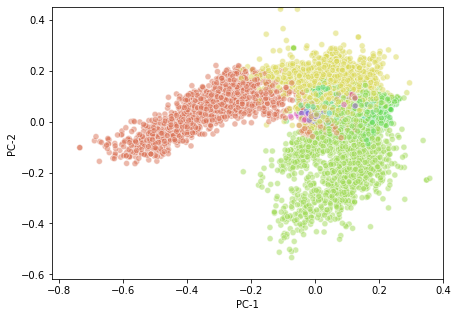

In [81]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="pca1", y="pca2",
    hue=tax_level,
    palette=sns.color_palette("hls", n_taxa),
    data=df_bpe_subset,
    legend=False,
    alpha=0.5
)
plt.xlim(None, 0.4)
plt.ylim(None, 0.45)
plt.xlabel('PC-1')
plt.ylabel('PC-2')

Text(0, 0.5, 'PC-2')

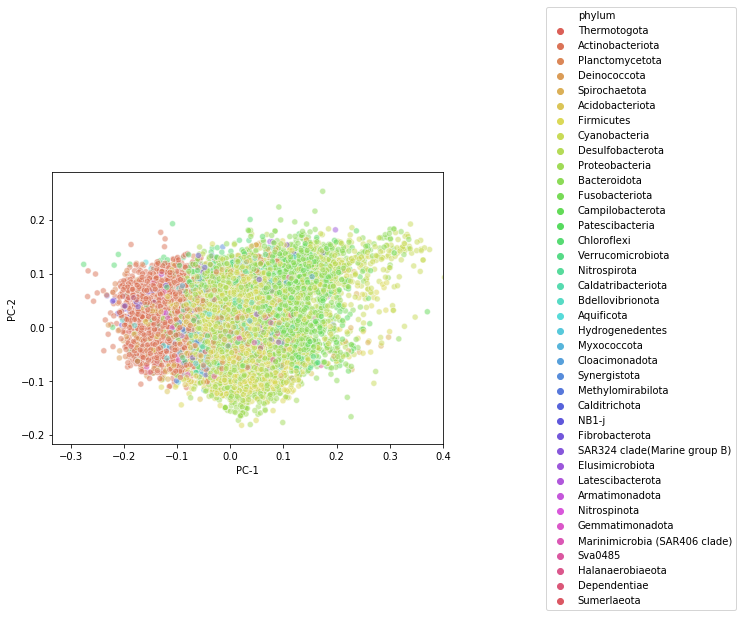

In [82]:
plt.figure(figsize=(7,5))
p = sns.scatterplot(
    x="pca1", y="pca2",
    hue=tax_level,
    palette=sns.color_palette("hls", n_taxa),
    data=df_kmer_subset,
    #legend=False,
    alpha=0.5
)
p.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xlim(None, 0.4)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
#plt.ylim(0, 20)

We compute the silhouette score for each pca to see if one better seperates phyla than the other

In [70]:
silhouette_avg_bpe = silhouette_score(X = df_bpe[['pca1', 'pca2', 'pca3']].values, 
                                      labels = df_bpe[tax_level], 
                                      sample_size = 20000, 
                                      random_state = 11)
print("For BPE tokens, the average silhouette_score is :", silhouette_avg_bpe)

For BPE tokens, the average silhouette_score is : -0.12573133295737587


In [71]:
silhouette_avg_kmer = silhouette_score(X = df_kmer[['pca1', 'pca2', 'pca3']].values, 
                                       labels = df_kmer[tax_level], 
                                       sample_size = 20000, 
                                       random_state = 11)
print("For k-mer tokens, the average silhouette_score is :", silhouette_avg_kmer)

For k-mer tokens, the average silhouette_score is : -0.3492087640456202


#### T-Distributed Stochastic Neighbouring Entities (t-SNE)

An important note about t-SNE caveats: https://distill.pub/2016/misread-tsne/

For t-SNE we use a random subset of 10K sequences

In [33]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(df_bpe_subset[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# Extract t-SNE results and add to table
df_bpe_subset['tsne-2d-one'] = tsne_results[:,0]
df_bpe_subset['tsne-2d-two'] = tsne_results[:,1]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.497s...
[t-SNE] Computed neighbors for 10000 samples in 116.604s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.149488
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.369606
[t-SNE] KL divergence after 1000 iterations: 0.894609
t-SNE done! Time elaps

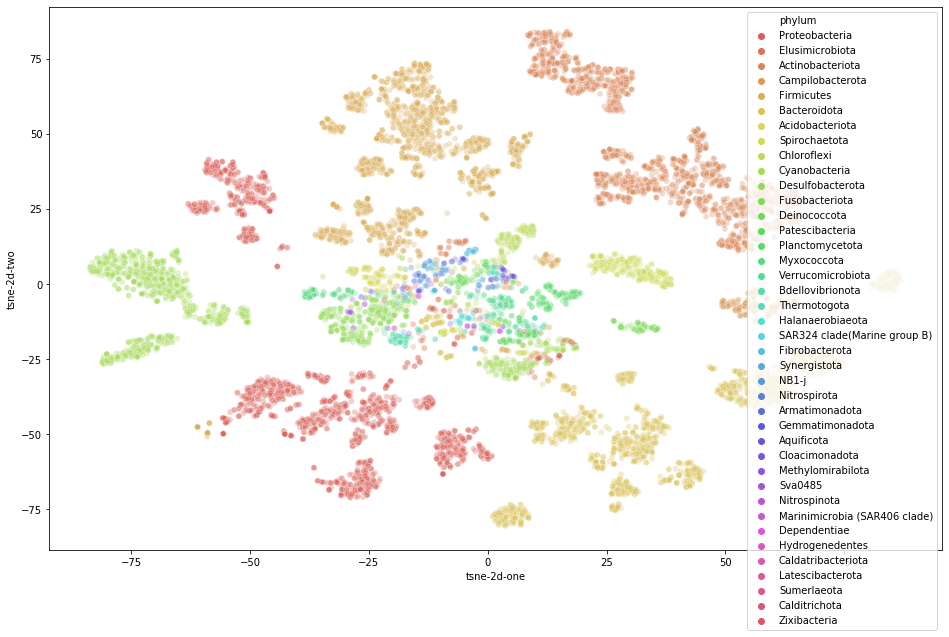

In [34]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=tax_level,
    palette=sns.color_palette("hls", n_taxa),
    data=df_bpe_subset,
    legend="full",
    alpha=0.3
)

In [35]:
# Same for k-mers
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(df_kmer_subset[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# Extract t-SNE results and add to table
df_kmer_subset['tsne-2d-one'] = tsne_results[:,0]
df_kmer_subset['tsne-2d-two'] = tsne_results[:,1]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.544s...
[t-SNE] Computed neighbors for 10000 samples in 105.673s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.096352
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.897545
[t-SNE] KL divergence after 1000 iterations: 1.572135
t-SNE done! Time elaps

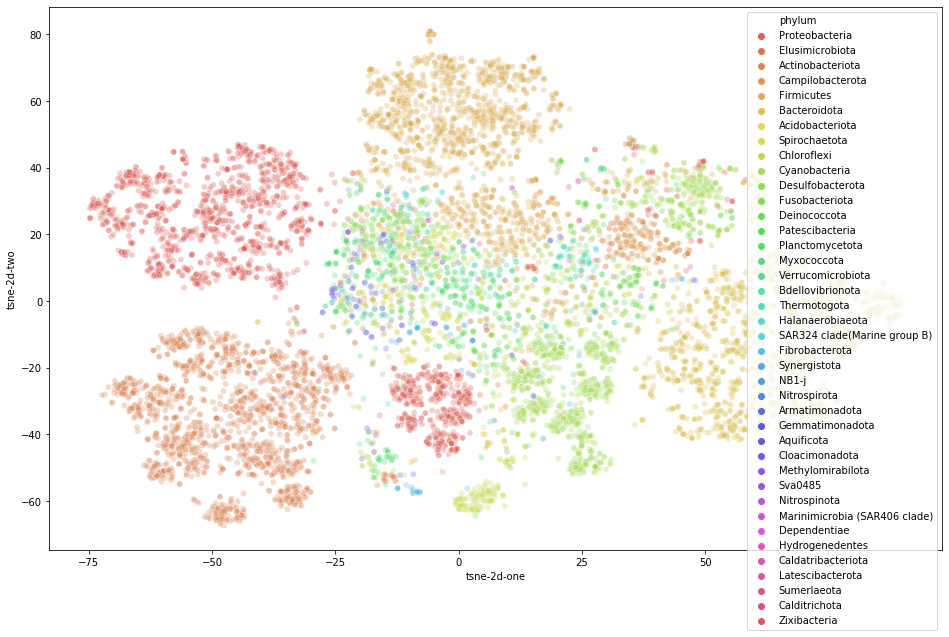

In [36]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=tax_level,
    palette=sns.color_palette("hls", n_taxa),
    data=df_kmer_subset,
    legend="full",
    alpha=0.3
)